

<font size = "5"> **Chapter 4: [Spectroscopy](CH4_00-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



##  Fit of Zero-Loss Peak

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_02-Fit_Zero_Loss.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2024

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



### Content

The zero-loss peak in an EELS spectrum gives us two important infomations:
    * the origin of the energy-scale
    * the zero-loss peak is the resolution function of our spectrum
    
Often we need to subtract or know this resolution function very accurately for a precise analysis of EELS spectra.

The area under the peak gives us the number of electron that are not inelatically scattered, and in relation to the total count a measure for the thickness of the sample.

### Energy Resolution and Zero-Loss Peak

The first peak in the Electron Energy Loss Spectrum (EELS) is the so called ``Zero-Loss`` peak.
This zero-loss peak is formed by all the electrons that are
- not scattered, 
- elastically scattered, and
- quasi--elastically scattered.


**We can use it as a measure of the energy resolution of the system.**

This is called a response function in information theory.


The full width at half maximum (FWHM) of the ``Zero-Loss peak`` is what we usually declare as energy resolution in an EELS spectrum.

The energy resolution has three sources:
- the energy spread of the electrons before they reach the specimen ($\Delta E_0$),
- the energy spread that is added by quasi-elastic interactions with the specimen($\Delta E_{ph}$),
- the spectrometer resolution ($\Delta E_{S_0}$),
- the energy dispersion ($s/D$).

These components usually treated as independent and summed up as squares of their values.
The measured  resolution $\Delta$E is given by:

\begin{equation} \Large 
\Delta{\rm E}^2 \approx \Delta E_0^2 + \Delta E_{S_0}^2 + (s/D)^2
\end{equation}
   
Please note that  the quasi-elastic interactions are not added here and, therefore, I assume to go through the vacuum only.

**Contribution of Electron Source**
 - The energy spread before the sample $\Delta$E$_0$ is the energy spread of the electron source broadened by the Boersch effect. 
- The energy spread of the source is a directly proportional to the temperature due to the Fermi--Dirac  distribution. 
- The Boersch effect is an additional broadening caused by the Coulomb interaction of the electrons, and is therefore more pronounced in higher density electron beams.
- Monochromators  will select a part of the original energy spread and thus increase energy resolution.
**Contribution of Spectrometer**
- The spectrometer resolution $\Delta$E$_{S0}$ is due to the aberration of the electron optics.
- This aberration is worse for larger collection angles.
- Aberration correctors will improve the spectrometer resolution.

**Contribution of Detector**

The spatial resolution of the electron detector $s$ (equivalent to the width of the slid  of a serial spectrometer) and the spectrometer dispersion $D$ are the final contributions to the total energy resolution.
**Choices of Dispersion**
- A small energy dispersion will allow a high energy resolution\\
- A large energy dispersion enables to samples a large energy window 


### Load important packages

#### Check Installed Packages


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2023.3.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

    
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import leastsq  ## fitting routine of scipy

# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
from pyTEMlib import eels_tools  

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Symmetry functions of spglib enabled
pyTEM version:  0.2023.3.0


### Load and plot a spectrum
please see [Introduction to EELS](CH4_01-Introduction.ipynb) for details

<IPython.core.display.Javascript object>


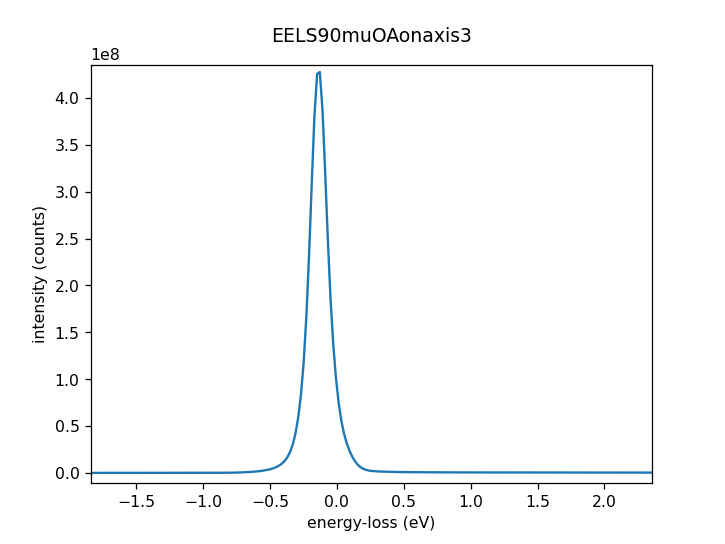

In [10]:
# Load file
filename = '../../MSE672-Introduction-to-TEM/example_data/AL-DFoffset0.00.dm3'
datasets = ft.open_file(filename)
eels_dataset = datasets['Channel_000']
if eels_dataset.data_type.name != 'SPECTRUM':
    print('We need an EELS spectrum for this notebook')
view = eels_dataset.plot()

### Important Parameters in an EELS spectrum

In [11]:
eels_dataset.view_metadata()

experiment :
	single_exposure_time : 0.1
	exposure_time : 10.0
	number_of_frames : 100
	collection_angle : 100.0
	convergence_angle : 0.0
	microscope : Libra 200 MC
	acceleration_voltage : 199990.28125
filename : ../../MSE672-Introduction-to-TEM/example_data/AL-DFoffset0.00.dm3


### Simple Zero-Loss Integration

The inelastic mean free path is hard to determine and depends on the effective collection angle (convolution of collection and convergence angle) and the acceleration voltage. None of these parameters are likely to be tabulated for your experimental set-up.

However, the relative thickness is a valuable parameter to judge your sample location and the validity of your spectrum.


In a good sample 70 to 90% of the electrons do not interact. 
The relative thickness $t$ in terms of the inelatic mean free path (IMFP) is given by:
$$ t = \ln\left(\frac{I_{total}}{I_{ZL}} \right) * IMFP$$

with:

$I_{total}$: total intensity of spectrum

$I_{ZL}$:  intensity of zero-loss peak

We first estimate the intensity of the zero-loss peak by a summation of the spectrum in a specific energy-loss range.


In [12]:
spectrum = np.array(eels_dataset)
energy_scale = eels_dataset.energy_loss.values
offset = eels_dataset.energy_loss[0]
dispersion = ft.get_slope(eels_dataset.energy_loss)
start = int((-2-offset)/dispersion)
end   = int((4-offset)/dispersion)

sumZL = sum(spectrum[start:end])
sumSpec = sum(spectrum)

print(f"Counts in zero-loss {sumZL:.0f} , total counts {sumSpec:.0f}")
print(f"{(sumSpec-sumZL)/sumSpec*100:.1f} % of spectrum interact with specimen")      

tmfp = np.log(sumSpec/sumZL)
print ('Sample thickness in Multiple of the ')
print (f'thickness [IMFP]: {tmfp:.3f}')


Counts in zero-loss 4123429588 , total counts 4875544752
15.4 % of spectrum interact with specimen
Sample thickness in Multiple of the 
thickness [IMFP]: 0.168


### Fitting the Zero-Loss with a Gausian
While a Gaussian does not describe the shape of the zero-loss peak well, we will use it to determine the zero-loss peak position.


The energy resolution is best measured from the zero-loss without sample (through vacuum), because the quasi elastic scattering will result in a small but noticeable broadening of the zero-loss.


The maximum of the fitted Gaussian is then the origin of the energy scale.

In [13]:
###
# This function is also in the eels_tools of pyTEMlib

def fix_energy_scale( spec, energy):
    
    startx = np.argmax(spec)
    end = startx+3
    start = startx-3
    for i in range(10):
        if spec[startx-i]<0.3*spec[startx]:
            start = startx-i
        if spec[startx+i]<0.3*spec[startx]:
            end = startx+i
    if end-start<3:
        end = startx+2
        start = startx-2
    
    x = np.array(energy[start:end])
    y = np.array(spec[start:end]).copy()
    
    y[np.nonzero(y<=0)] = 1e-12


    def gauss(x, p): # p[0]==mean, p[1]= area p[2]==fwhm, 
        return p[1] * np.exp(-(x- p[0])**2/(2.0*( p[2]/2.3548)**2))

    def errfunc(p, x, y):
        err = (gauss(x, p)-y )/np.sqrt(y) # Distance to the target function
        return err
    
    p0 = [energy[startx],1000.0,1] # Inital guess is a normal distribution
    p1, success = leastsq(errfunc, p0[:], args=(x, y))

    fit_mu, area, FWHM = p1
    
    return FWHM, fit_mu

In [14]:
FWHM, fit_mu = fix_energy_scale(spectrum, energy_scale)
print(f'FWHM: {FWHM:.2f} eV , with shift of {fit_mu:.2f} eV')

FWHM: -0.18 eV , with shift of -0.13 eV


Fit of Zero Loss from channel  131  to  229
Fit of Zero Loss from   -0.9727127428128597 eV to  0.9996566188559655 eV
Zero-loss position was -0.13 eV
Corrected energy axis
Width (FWHM) is 0.20 eV
Probability  is 79.14 %
Thickness is 0.234 * IMFP
Goodness of Fit:  2.603746027238543 %


<IPython.core.display.Javascript object>


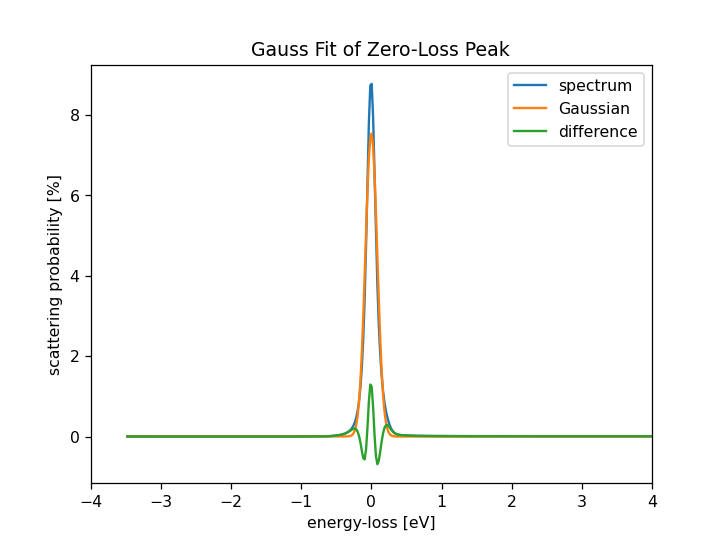

Sum of Gaussian:  3858665453.384109
Sum of Spectrum:  4875544600.0
thickness [IMFP]:  0.23391041987787786


In [15]:
# --- Input -----
Gap = 1
# ---------------
## energy range of fit
startx = int(abs(offset/dispersion ))+1 ## zero eV
widthx = int(abs(Gap   /dispersion )) ## fit width
## We need 6 parameter to fit the resolution function
## and so at least 6 channels for the fit
if widthx*2 < 6:
    Gap = 3*dispersion
    widthx = 3

endx = int(startx+widthx)
startx = int(startx-widthx)

print('Fit of Zero Loss from channel ', startx, ' to ',endx)
print('Fit of Zero Loss from  ', startx*dispersion+offset, 'eV to ',endx*dispersion+offset, 'eV')

# energy scale and spectrum in the fitting window
x = energy_scale[startx:endx]
y = np.array(spectrum[startx:endx]).flatten()


def gauss(x, p): 
    """
    Gaussian distribution
    Input: 
    p: list or array  p[0]=position, p[1]= area p[2]==fwhm, 
    x: energy axis 
    """
    p[2] = abs(p[2])
    return p[1] * np.exp(-(x- p[0])**2/(2.0*( p[2]/2.3548)**2))


# Fit a Gaussian
y[np.nonzero(y<=0)] = 1e-12
p0 = [0,1000.0,1] # Inital guess is a normal distribution
errfunc = lambda p, x, y: (gauss(x, p) - y)/np.sqrt(y) # Distance to the target function
p1, success = leastsq(errfunc, p0[:], args=(x, y)) # The Fit

print(f'Zero-loss position was {p1[0]:.2f} eV')
energy_scale=energy_scale-p1[0]
print('Corrected energy axis')
p1[0]=0.0
Gauss = gauss(energy_scale,p1)


print(f'Width (FWHM) is {p1[2]:.2f} eV')
print(f'Probability  is {sum(Gauss)/sumSpec*1e2:.2f} %')
tmfp = np.log(sumSpec/sum(Gauss))
print(f'Thickness is {tmfp:.3f} * IMFP')

err = (y - gauss(x, p1))/np.sqrt(y)
print ('Goodness of Fit: ' ,sum(err**2)/len(y)/sumSpec*1e2, '%')


abs(offset/dispersion )
start =int((-2-offset)/dispersion)
end = int((8-offset)/dispersion)

plt.figure()

plt.plot(energy_scale, spectrum/sumSpec*1e2,label='spectrum')
plt.plot(energy_scale, Gauss/sumSpec*1e2, label='Gaussian')
plt.plot(energy_scale, (spectrum-Gauss)/sumSpec*1e2, label='difference')
plt.legend()
plt.title ('   Gauss Fit of Zero-Loss Peak')
plt.xlim(-4,4)
Izl = Gauss.sum()
Itotal = spectrum.sum()
tmfp = np.log(Itotal/Izl)
print('Sum of Gaussian: ', Izl)
print('Sum of Spectrum: ', Itotal)
print ('thickness [IMFP]: ', tmfp)
plt.ylabel('scattering probability [%]')
plt.xlabel('energy-loss [eV]');

In the above figure, we show a zero-loss peak fitted with a Gaussian. 
- zoom in so that you can see the zero-Loss only.
- The zero--loss peak is about 8% high and you can read off the FWHM by going left and right where the zero-loss peak reaches 4%. 

- Therefore, the FWHM of this zero-loss peak is about 0.18 eV. This is obviously a high resolution spectrum.
- Also, the shape of the zero-loss is not perfectly symmetric and the tails of the zero-loss peak extend far in both directions. 
- The position of the maximum of the zero-loss peak is used for calibrating the energy scale. The maximum indicates zero energy--loss.                                                                                                                                    

### Fitting the Zero-Loss with a Product of Two Lorentzians
To better describe the full shape we use the product of two Lorentzians.

Compare the residuals of the Gaussian and Lorentzian fit. 

You will zoom in closely to see the difference between experimental and model zero-loss peak here.

In [16]:
#################################################################
## fit Zero Loss peak with ZLfunct =
##  = convolution of Gauss with a product of two Lorentzians
##################################################################        
width = 30


startx = np.argmax(spectrum)
endx = startx+width
startx = startx-width
print (startx, endx, endx-startx)


x = np.array(energy_scale[startx:endx])
y = np.array(spectrum[startx:endx])

print(f"Energy range for fit of zero-loss: {energy_scale[startx]:.2f} to {energy_scale[endx]:.2f}")

#guess = [0.02, 8000000, 0.1, 0.2, 1000,0.2,0.5, 1000,-0.5,-1.3, 1.01,1.0]
guess = [ 0.2, 1000,0.02,0.2, 1000,0.2 ]

p0 = np.array(guess)

def ZL(p, y, x):
    err = (y - eels_tools.zl_func(p,  x))#/np.sqrt(y)
    return err

pZL, lsq = leastsq(ZL, p0, args=(y, x), maxfev=2000)
print('Fit of a Product of two Lorentzians')
print('Positions: ',pZL[2],pZL[5], 'Distance: ',pZL[2]-pZL[5])
print('Width: ', pZL[0],pZL[3])
print('Areas: ', pZL[1],pZL[4])
err = (y - eels_tools.zl_func(pZL,  x))/np.sqrt(np.abs(y))
print (f'Goodness of Fit: {sum(err**2)/len(y)/sumSpec*1e2:.5}%')

zLoss = eels_tools.zl_func(pZL, energy_scale)

143 203 60
Energy range for fit of zero-loss: -0.60 to 0.61
Fit of a Product of two Lorentzians
Positions:  0.031005069105874184 -0.01913087678679115 Distance:  0.05013594589266533
Width:  0.2949903490324435 0.19179393670534314
Areas:  7540.136606887233 8678.563407533855
Goodness of Fit: 0.0027237%


<IPython.core.display.Javascript object>


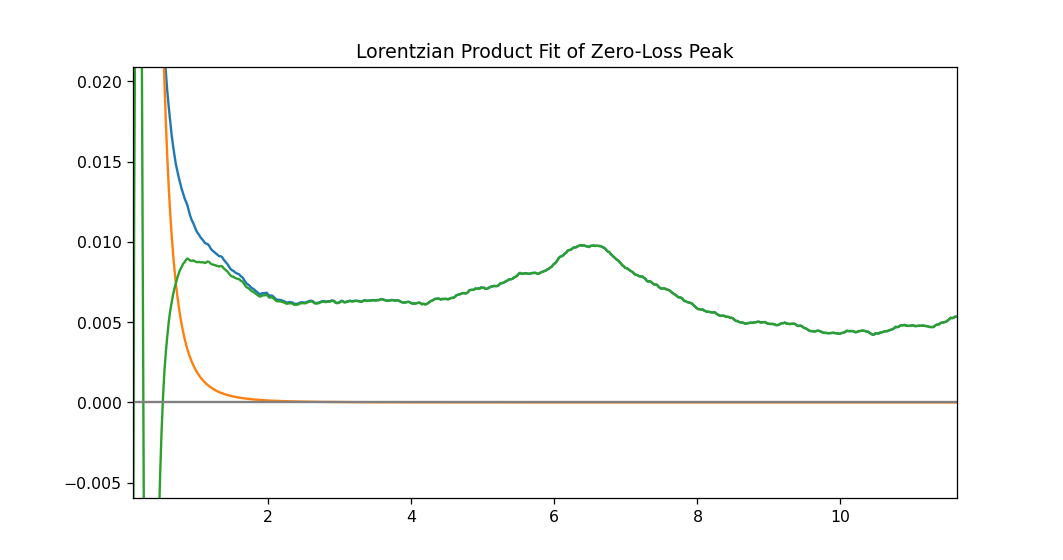

Sum of Zero-Loss: 4083171525 counts
Sum of Spectrum: 4875544576 counts
thickness [IMFP]: 0.17736


In [17]:
fig = plt.figure()
plt.plot(energy_scale,spectrum/sumSpec*1e2 , label = 'spectrum')

plt.plot(energy_scale,   zLoss/sumSpec*1e2, label ='resolution function')
plt.plot(energy_scale,  (spectrum-zLoss)/sumSpec*1e2 , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,5)
plt.hlines(0, energy_scale[0], energy_scale[-1],color = 'gray')
Izl = zLoss.sum()
fig.show()
Itotal = spectrum.sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.0f} counts')
print(f'Sum of Spectrum: {Itotal:.0f} counts')
print (f'thickness [IMFP]: {tmfp:.5f}')

### Calibrating Energy Dispersion
- The software controlling the spectrometer (or image filter) will allow you to select your energy dispersion.
- The dispersion is set through the magnification within the spectrometer and each dispersion setting is internally a set of values for the lenses (quadrupoles).
- This setting will only be accurate to about 10\% which is not accurate enough to automatically rely on it.
- Therefore, we usually calibrate the energy dispersion ourselves.                        
- The drift tube high voltage power supply is reasonable accurate to do this dispersion calibration.

**Practical Steps**
- We collect a zero--loss (preferably but not necessarily in vacuum) without applied drift tube voltage. The zero--loss should be at the right  hand of the display.
- Then we collect a zero--loss peak with applied drift tube voltage, so that the zero-loss peak is at the left side of the display. 

<img title="EELS dispersion calibration" width="50%" alt="EELS dispersion calibration" src="images/energy-calibration2.jpg">


- We now measure the number of channels between the two zero-loss peaks (make sure that there is no other energy dispersion selected. 
- We divide the voltage by this number and get the accurate energy dispersion. 
- In the case of the spectrum in figure above  it is   300 eV /  265 channels = 1.17 eV/channel.


**The selected energy dispersion was  1.0  eV / channel.**


### Conclusion

We use a Gaussian fit to determine the zero energy channel and thus the origin of the energy-scale

We use a product of two Lorentzians to fit the zero-loss peak, we will use that fit as the resolution function for further analysis (everythin we measure is convoluted by that function).

Here we used the area under the zero-loss peak to determine the relative thickness ( a relative thickness of 0.3 * IMFP is considered ideal for most experiments)

### Navigation
- <font size = "3">  **Up Chapter 4: [Imaging](CH4_00-Spectroscopy.ipynb)** </font>
- <font size = "3">  **Back: [Overview](CH4_01-Introduction.ipynb)** </font>
- <font size = "3">  **Next: [Analysing Low-Loss Spectra with Drude Theory](CH4_03-Drude.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>